## Setup and Installation

In [ ]:
# %pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing


In [ ]:
import tensorflow_datasets as tfds

# Extract EMNIST data
def extract_data(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image.numpy())  
        labels.append(label.numpy())  
    return np.array(images), np.array(labels)

def load_emnist_letters():
    dataset = tfds.load('emnist/letters', as_supervised=True)

    train_data, test_data = dataset['train'], dataset['test']

    x_train, y_train = extract_data(train_data)
    x_test, y_test = extract_data(test_data)

    # remove extra dimension for plotting
    x_train = x_train.squeeze(axis=-1) 
    x_test = x_test.squeeze(axis=-1)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_emnist_letters()

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

Training data shape: (88800, 28, 28)
Test data shape: (14800, 28, 28)
Number of classes: 26


2025-05-12 22:43:13.009286: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


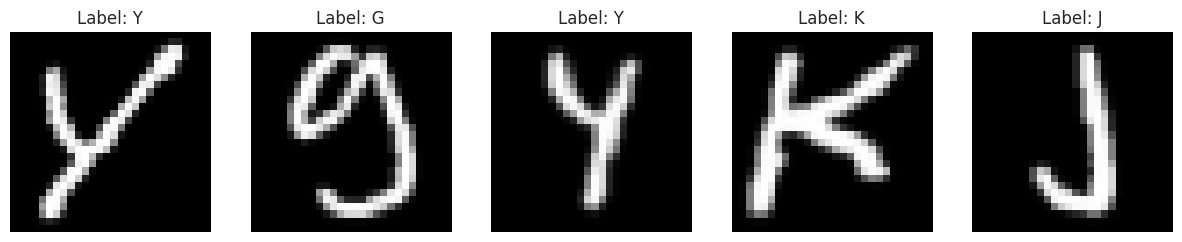

In [ ]:
# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].T, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [40]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for dense layers
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)


# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 784)
Preprocessed validation data shape: (17760, 784)
Preprocessed test data shape: (14800, 784)



## 2. Model Implementation

In [41]:
from tensorflow.keras import layers
# Create simple neural network
def create_simple_nn(input_shape, num_classes):
    """
    Create a simple neural network for EMNIST classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 80% accuracy on test set
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (784,) for flattened 28x28 images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """

    model = tf.keras.Sequential([
        layers.Input(input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')

    ])
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(784,), num_classes=26)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 539,930 (2.06 MB)

 Trainable params: 539,930 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training and Evaluation

Epoch 1/20


2025-05-12 23:23:11.700513: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 222781440 exceeds 10% of free system memory.


2220/2220 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6648 - loss: 1.1245 - val_accuracy: 0.8636 - val_loss: 0.4358 - learning_rate: 0.0010
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8474 - loss: 0.4738 - val_accuracy: 0.8848 - val_loss: 0.3630 - learning_rate: 0.0010
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8740 - loss: 0.3840 - val_accuracy: 0.8910 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8861 - loss: 0.3356 - val_accuracy: 0.8958 - val_loss: 0.3209 - learning_rate: 0.0010
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8961 - loss: 0.3032 - val_accuracy: 0.8973 - val_loss: 0.3276 - learning_rate: 0.0010
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9021 - loss: 0.2780 - val_accuracy: 0.8989 - val_loss: 0.3286 - learning_rate: 0.0010
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9097 - loss:

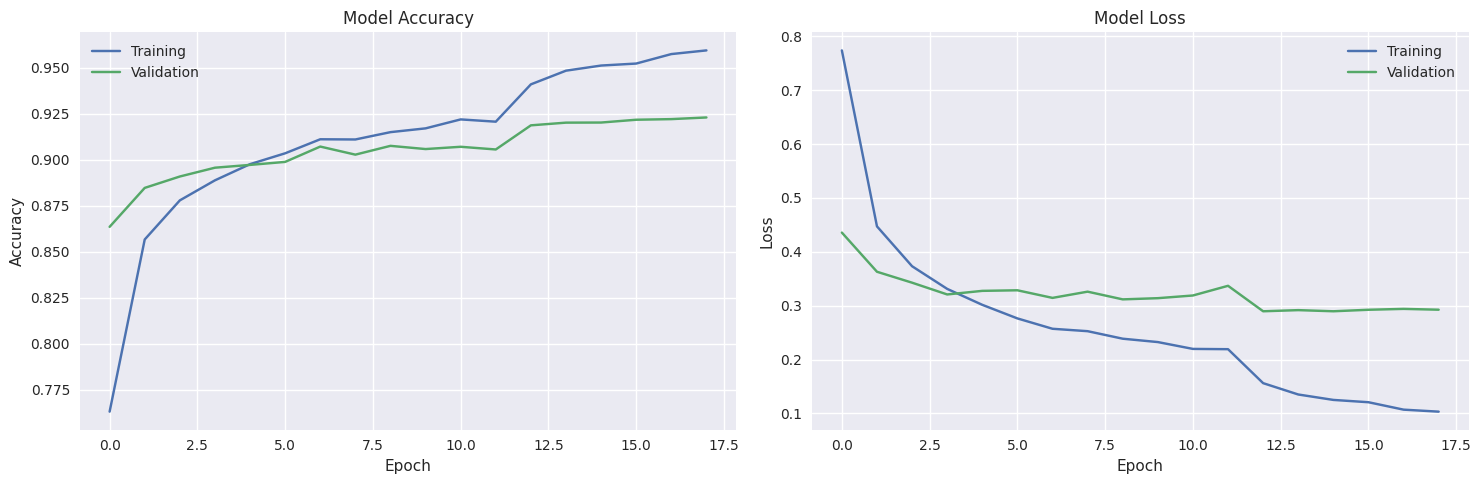

In [42]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9091 - loss: 0.3317
Test accuracy: 0.9066
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


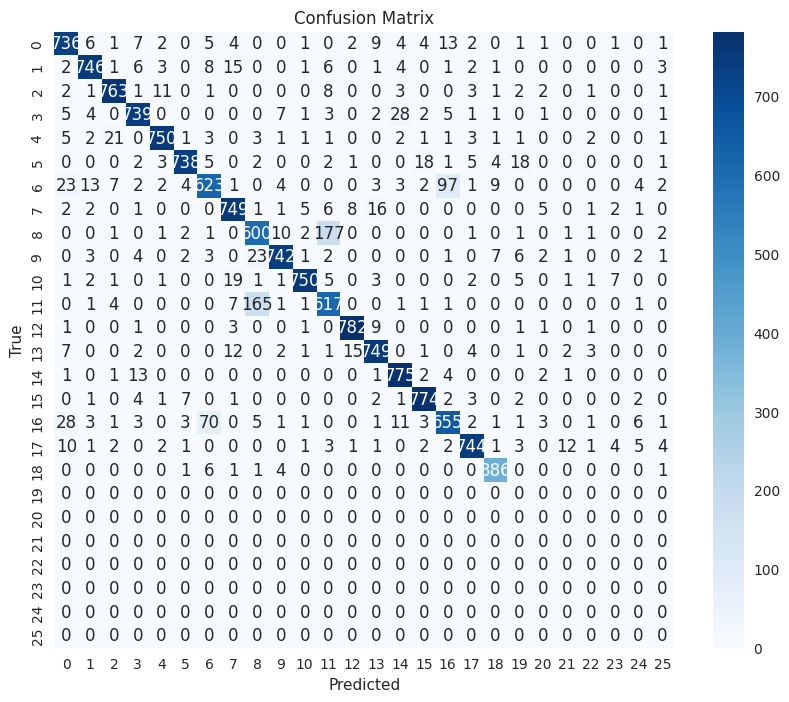

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# calculate precision, recall, and f1 score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")